In [1]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import matplotlib.pyplot as plt

In [2]:
def file_name(file_dir):   
    L=[]   
    for root, dirs, files in os.walk(file_dir):  
        for file in files:  
            if os.path.splitext(file)[1] == '.h5':
                L.append(os.path.join(root, file)[29:-3])  
    return L # file name = id

In [3]:
def open_genre_1(lst):
    f = open('genre.txt','r')
    dic = {}
    Set = []
    id_genre = {}
    for i in f.readlines():
        content = i.split()
        content[-1] = content[-1][:-1]
        if len(content) == 3:
            content[1] = content[1]+" "+content[2]
        if len(content) == 1:
            continue
        dic[content[0]] = content[1]
        Set.append(content[1])
    genre = list(set(Set))
    # print(genre)
    # print(len(set(Set)))
    number = [0]*15
    for j in lst:
        if j in dic:
            id_genre[j] = dic[j]
    for m in id_genre:
        number[genre.index(id_genre[m])] +=1
    # print(number)
    # print(sum(number))
    return id_genre, genre

In [4]:
def open_genre_2(lst,id_genre):
    g = open('newgenre.txt','r')
    dic2 = {}
    # Set2 = []
    for k in g.readlines():
        content = k.split()
        if len(content) == 3:
            content[1] = content[1]+" "+content[2]
        if len(content) == 1:
            continue
        dic2[content[0]] = content[1]
    #     Set2.append(content[1])
    # genre2 = list(set(Set2))
    # print(genre2)
    # print(len(set(Set2)))
    for item in lst:
        if (item not in id_genre) and (item in dic2) and dic2[item] != "Pop_Rock" and dic2[item] != "International" and dic2[item] != "Vocal":
            id_genre[item] = dic2[item]
    # print(len(id_genre))
    return id_genre

In [5]:
def data_pre_process(updated_id_genre):
    processed_data = {}
    x = []
    y = []
    lenlist = []
    for k,v in updated_id_genre.items():
        lst = []
        for root, dirs, files in os.walk("MillionSongSubset/data"):
            for file in files:
                if os.path.splitext(file)[0] == k:
                    f = h5py.File(os.path.join(root, file), 'r')
                    for i in f['analysis']["segments_timbre"]:
                        for m in list(i):
                            lst.append(m)
        if len(lst)>=4800:
            Array = np.array(lst[:4800])
            processed_data[k] = [v,Array]
            x.append(Array)
            y.append(v)
    return processed_data, x, y

In [6]:
lst = file_name("MillionSongSubset/data")

id_genre, genre = open_genre_1(lst)
# genre = ['Rock', 'Country', 'New Age', 'Jazz', 'Folk', 'Blues', 'Pop', 'Metal', 'World', 'Reggae', 'Electronic', 'Punk', 'Rap', 'RnB', 'Latin']
updated_id_genre = open_genre_2(lst,id_genre)
print(len(updated_id_genre))

3396


In [7]:
processed_data, x, y= data_pre_process(updated_id_genre)
print(len(processed_data))
print(len(x))

3190
3190


In [65]:
X_all = np.array(x).reshape(3190,1,400,12)
# X_all = np.array(x).reshape(3190,12,20,20)
# for i in range(len(y)):
#     y[i] = genre.index(y[i])
y_all = np.array(y)
X_train = X_all[:1500]
y_train = y_all[:1500]
X_val = X_all[1500:1690]
y_val = y_all[1500:1690]
X_test = X_all[1690:]
y_test = y_all[1690:]

In [70]:
class ConvNet(nn.Module):
 
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,padding = 1)
        self.conv2 = nn.Conv2d(16,32,3,padding = 1)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(64*98,1000)
        self.fc2 = nn.Linear(1000, 240)
        self.fc3 = nn.Linear(240,15)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.conv3(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(12, 32, 3, 1, 1) 
#         self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
#         self.fc1 = nn.Linear(64 * 20 * 20, 128)
#         self.fc2 = nn.Linear(128, 32)
#         self.fc3 = nn.Linear(32, 15)
#         #Three linear layers

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x  = x.view(-1,64 * 20 * 20)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [71]:
# init network
conv_net = ConvNet()
print('model structure: ', conv_net)
# init optimizer
optimizer = optim.Adam(conv_net.parameters(), lr=0.001, weight_decay=1e-5)
# set loss function
criterion = nn.CrossEntropyLoss()

# prepare for mini-batch stochastic gradient descent
n_iteration = 25
batch_size = 64
n_data = X_train.shape[0]
n_batch = int(np.ceil(n_data/batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = torch.Tensor(X_train)
X_val_tensor = torch.Tensor(X_val)

# convert training label to tensor and to type long
y_train_tensor = torch.Tensor(y_train).long()
y_val_tensor = torch.Tensor(y_val).long()

print('X train tensor shape:', X_train_tensor.shape)

model structure:  ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=240, bias=True)
  (fc3): Linear(in_features=240, out_features=15, bias=True)
)
X train tensor shape: torch.Size([1500, 1, 400, 12])


In [72]:
def get_correct_and_accuracy(y_pred, y):
    # y_pred is the nxC prediction scores
    # give the number of correct and the accuracy
    n = y.shape[0]
    # find the prediction class label
    _ ,pred_class = y_pred.max(dim=1)
    correct = (pred_class == y).sum().item()
    return correct ,correct/n

In [73]:
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)
for i in range(n_iteration):
    # first get a minibatch of data
    running_loss = 0
    correct_train = 0
    for j in range(n_batch):
        batch_start_index = j*batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]
        pred = conv_net(X_batch)
        loss = criterion(pred, y_batch)
        running_loss += loss.item()
        correct_train += get_correct_and_accuracy(pred, y_batch)[0]
        # update 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ave_train_loss = running_loss / n_batch
    pred_val = conv_net(X_val_tensor)
    loss_val = criterion(pred_val, y_val_tensor)
    val_loss = loss_val
    train_accu = correct_train/float(n_data)
    val_accu =  get_correct_and_accuracy(pred_val, y_val_tensor)[1]

    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f" 
          %(i ,ave_train_loss, train_accu, val_loss, val_accu)) 
    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = train_accu
    val_loss_list[i] = val_loss
    val_accu_list[i] = val_accu

Iter 0 ,Train loss: 5.336, Train acc: 0.265, Val loss: 2.305, Val acc: 0.374
Iter 1 ,Train loss: 1.989, Train acc: 0.421, Val loss: 2.009, Val acc: 0.458
Iter 2 ,Train loss: 1.751, Train acc: 0.464, Val loss: 1.931, Val acc: 0.442
Iter 3 ,Train loss: 1.528, Train acc: 0.519, Val loss: 1.909, Val acc: 0.463
Iter 4 ,Train loss: 1.266, Train acc: 0.595, Val loss: 1.989, Val acc: 0.474
Iter 5 ,Train loss: 0.943, Train acc: 0.713, Val loss: 2.142, Val acc: 0.411
Iter 6 ,Train loss: 0.703, Train acc: 0.793, Val loss: 1.979, Val acc: 0.484
Iter 7 ,Train loss: 0.573, Train acc: 0.821, Val loss: 2.105, Val acc: 0.395
Iter 8 ,Train loss: 0.376, Train acc: 0.903, Val loss: 2.852, Val acc: 0.311
Iter 9 ,Train loss: 0.248, Train acc: 0.939, Val loss: 3.615, Val acc: 0.368
Iter 10 ,Train loss: 0.187, Train acc: 0.947, Val loss: 3.066, Val acc: 0.358
Iter 11 ,Train loss: 0.119, Train acc: 0.971, Val loss: 3.583, Val acc: 0.453
Iter 12 ,Train loss: 0.117, Train acc: 0.964, Val loss: 3.556, Val acc: 0.

In [74]:
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test).long()
pred = conv_net(X_test_tensor)
correct_train = get_correct_and_accuracy(pred, y_test_tensor)[1]
print("Test accuracy: ", correct_train)

Test accuracy:  0.24733333333333332


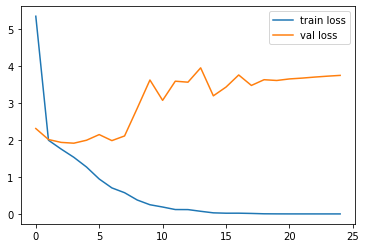

In [75]:
import matplotlib.pyplot as plt
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

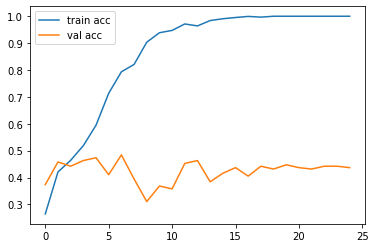

In [76]:
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()